In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

In [5]:
data_path = './Data/'
data_name_lst = [name for name in os.listdir(data_path) if name.startswith('Fill')]
data_name_lst

['FillByAll4_2018_.csv',
 'FillByAll4_2019_.csv',
 'FillByAll4_2020_.csv',
 'FillByAll4_2021_.csv',
 'FillByAll4_2022_.csv']

In [6]:
data_dict = {i.split('_')[1]: pd.read_csv(os.path.join(data_path, i)) for i in data_name_lst}
data_dict

{'2018':            Date   05T        10T        11T   59T   61T        03T   50T  \
 0    2018_01_01  17.0  23.500000  23.500000  21.0  30.0  23.500000  27.0   
 1    2018_01_02  25.0  28.000000  28.000000  26.0  33.0  28.000000  30.0   
 2    2018_01_03  34.0  37.666667  37.666667  38.0  42.0  37.666667  40.0   
 3    2018_01_04  41.0  41.166667  41.166667  39.0  45.0  41.166667  45.0   
 4    2018_01_05  42.0  47.000000  47.000000  51.0  53.0  47.000000  51.0   
 ..          ...   ...        ...        ...   ...   ...        ...   ...   
 359  2018_12_27  60.0  61.000000  55.000000  49.0  46.0  71.000000  44.0   
 360  2018_12_28  65.0  62.000000  62.000000  60.0  26.0  71.000000  46.0   
 361  2018_12_29  25.0  22.000000  26.000000  18.0  20.0  29.000000  25.0   
 362  2018_12_30  14.0  19.000000  20.000000  19.0  22.0  21.000000  24.0   
 363  2018_12_31  17.0  22.000000  21.000000  14.0  24.0  20.000000  22.0   
 
       52T  53T  ...   75T        68T        69T        70T   76T 

In [13]:
np.array(list(data_dict['2018'].columns)) != 'Date'

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [19]:
data_dict['2018'].sum(axis=1, numeric_only=True)

0      1083.285714
1      1314.785714
2      1597.338095
3      1866.428571
4      2143.283333
          ...     
359    2429.000000
360    2476.000000
361    1257.000000
362     885.000000
363     922.000000
Length: 364, dtype: float64

In [22]:
data_dict['2018'].mean(axis=1, numeric_only=True)

0      20.439353
1      24.807278
2      30.138455
3      35.215633
4      40.439308
         ...    
359    45.830189
360    46.716981
361    23.716981
362    16.698113
363    17.396226
Length: 364, dtype: float64

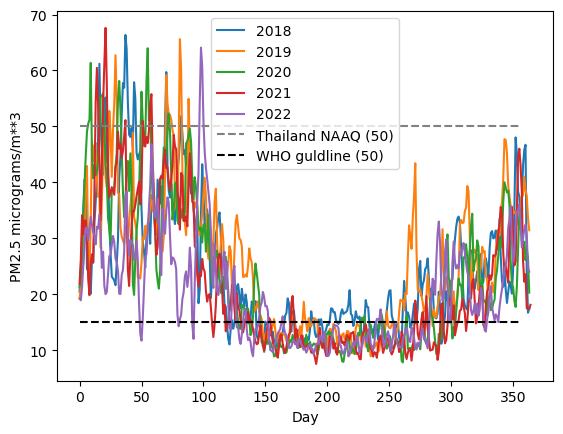

In [31]:
mean_data_dict = {}
for year, df in data_dict.items():
    mean_data_dict[year] = df.mean(axis=1, numeric_only=True)
for year, df in mean_data_dict.items():
    plt.plot(df, label=year)
plt.hlines(50, 0, 356, linestyles='dashed', label='Thailand NAAQ (50)', color='gray')
plt.hlines(15, 0, 356, linestyles='dashed', label='WHO guldline (50)', color='black')
plt.ylabel('PM2.5 micrograms/m**3')
plt.xlabel('Day')
plt.legend()
plt.show()

In [38]:
data_dict_month = {}
for year, df in data_dict.items():
    data_dict_month[year] = df.copy()
    data_dict_month[year]['Month'] = data_dict_month[year]['Date'].apply(lambda x: x.split('_')[1])
    data_dict_month[year] = data_dict_month[year].drop(columns=['Date'])

In [39]:
a = data_dict_month['2018']

In [41]:
a.groupby(['Month']).count()

,05T,10T,11T,59T,61T,03T,50T,52T,53T,54T,...,75T,68T,69T,70T,76T,42T,44T,62T,63T,80T
Month,,,,,,,,,,,,,,,,,,,,,
01,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
02,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28
03,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
04,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
05,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
06,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
07,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
08,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
09,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
